# Práctica 4


date: 10/10/2023  
File: practica_4_ej_1_y_2.ipynb  
Author : Pablo Naim Chehade   
Email: pablo.chehade.villalba@gmail.com  
GitHub: https://github.com/Lupama2  

## Ejercicio 1

En el algoritmo de back-propagation, en la fórmula (6.18) del Herz, es necesario agregar sobre h una componente extra que puede ser escencialmente cualquier cosa. ¿Por qué es necesario agregarla? Viene del hecho de que la neurona bias no tiene ningún input, pero las demás sí.

### Importo dependencias

In [1]:
#Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#Hago los gráficos interactivos
%matplotlib ipympl

#Fuente y tamaño de los caracteres en los gráficos
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 17}
matplotlib.rc('font', **font)

### Defino datos

In [2]:
#Def regla XOR
def XOR(x1, x2):
    #x1, x2: +1 o -1
    if x1 == x2:
        return 1
    else:
        return -1

#Def datos x e y
x_data = np.empty([4, 2])
y_data = np.empty(4)

x_data[0] = np.array([1,1])
x_data[1] = np.array([1,-1])
x_data[2] = np.array([-1,1])
x_data[3] = np.array([-1,-1])

for i in range(len(y_data)):
    y_data[i] = XOR(x_data[i][0], x_data[i][1])


### Defino funciones

In [3]:
#Def la aplicación de una red
def red_forward(x_test, red):
    V_0 = np.concatenate((x_test, np.array([-1])), axis = 0) #Agrego el bias 3x1
    for j in range(len(red["pesos"])):
        w = red["pesos"][j]
        h = np.dot(w.T, V_0)
        if j != len(red["pesos"]) - 1:
            V_1 = np.concatenate((g(h), np.array([-1])), axis = 0) #3x1
        else: #Si estoy en la última capa
            V_1 = g(h)
        V_0 = V_1
    return V_1[0]

#Def función de validación
def validacion(x_test, y_test, red):
    error = 0

    for i in range(len(y_test)):
        #Forward pass
        y_out = red_forward(x_test[i], red)

        #Aproximo y_out para que sea +1 o -1
        if y_out >= 0:
            y_out = 1
        else:
            y_out = -1

        #Calculo el error
        error += np.abs(y_test[i] - np.round(y_out))/2 #Da 0 si no hay error y 1 si hay error


    return error/len(y_test)

def e_loss(x_test, y_test, red):
    error = 0

    for i in range(len(y_test)):
        #Forward pass
        y_out = red_forward(x_test[i], red)
        #Calculo el error
        error += (y_test[i] - y_out)**2

    return error/2

#Def función de transferencia
def g(h_vec):
    return np.tanh(h_vec)

def g_prima(h_vec):
    return 1 - g(h_vec)**2

### Def redes

### Back-propagation

In [4]:

#Def algoritmo de retropropagación de errores
def back_propagation(x_data, y_data, red, eta):
    #Se usa la nomenclatura del Hertz

    #Loop sobre las muestras
    for i in range(len(y_data)):   
        #Forward pass
        V_0 = np.concatenate((x_data[i], np.array([-1])), axis = 0) #Agrego el bias 3x1
        w_1 = red["pesos"][0] #3x2
        
        h_1 = np.dot(w_1.T, V_0) #2x1
        V_1 = np.concatenate((g(h_1), np.array([-1])), axis = 0) #3x1

        w_2 = red["pesos"][1] #3x1
        h_2 = np.dot(w_2.T, V_1) #1x1
        V_2 = g(h_2) #1x1

        #Backward
        #Calculo el error de la capa de salida
        delta_2 = g_prima(h_2)*(y_data[i] - V_2) #1x1

        #Calculo el error de la capa oculta
        # delta_1 = g_prima(h_1)*np.dot(w_2, delta_2) #
        delta_1 = np.concatenate([g_prima(h_1),np.array([1])])*np.dot(w_2, delta_2) #3x1

        #Actualizo pesos
        w_1 += eta * np.outer(V_0, delta_1[:-1]) #3x2
        w_2 += eta * np.outer(V_1, delta_2)
        if red["name"] == "B":
            #Tengo que fijar algunos elementos de los pesos para que no varíen
            w_1[0,0] = 1; w_1[0,2] = 0
            w_1[1,0] = 0; w_1[1,2] = 1
            w_1[2,0] = 0; w_1[2,2] = 0
        
        red["pesos"] = [w_1, w_2]

    return red

#Def algoritmo de aprendizaje
def aprendizaje(x_data, y_data, red, eta, epochs = 1):
    #Def array de errores
    e_loss_vec = np.empty(epochs)
    validacion_vec = np.empty(epochs)

    #Loop sobre las epochs
    for i in range(epochs):
        #Backpropagation
        red = back_propagation(x_data, y_data, red, eta)
        
        #Cálculo de errores
        e_loss_vec[i] = e_loss(x_data, y_data, red)
        validacion_vec[i] = validacion(x_data, y_data, red)


    return red, e_loss_vec, validacion_vec


### Aprendizaje

Para cada arquitectura repito el entrenamiento con 10 condiciones iniciales distintas

In [5]:
np.random.seed(1) #def seed

In [6]:

N_CI = 10 #Nro de condiciones iniciales
N_epochs = 2000 #nro de epochs que voy a entrenar

def red_A(w_ini_max):
    #Cambia en cada llamada por los nros random
    return {"name": "A", "input":2, "hidden":2, "output":1, "pesos":[np.random.rand(3,2)*w_ini_max, np.random.rand(3,1)*w_ini_max]}

def red_B(w_ini_max):
    #Para modelar la neurona B, agrego en la capa oculta 2 neuronas que van a ser una copia directa de las neuronas previas correspondientes. Esto tengo que modificarlo a mano luego
    return {"name": "B" , "input":2, "hidden":2, "output":1, "pesos":[np.random.rand(3,3)*w_ini_max, np.random.rand(4,1)*w_ini_max]}


def aprendizaje_redes(N_CI, N_epochs, red, x_data, y_data, eta = 0.1):
    #red escrita como función, de modo de que cambie los pesos en cada CI

    w_ini_max = 1 #peso máximo en la inicialización

    e_loss_matrix = np.empty([N_CI, N_epochs])
    validation_matrix = np.empty([N_CI, N_epochs])

    for i in range(N_CI):

        #Entreno red
        model_A = aprendizaje(x_data, y_data, red(w_ini_max), eta, epochs = N_epochs)

        #Guardo el error
        e_loss_matrix[i] = model_A[1]
        validation_matrix[i] = model_A[2]

    #Calculo media y desviación estándar de la media de los errores a cada tiempo
    e_loss_mean = np.mean(e_loss_matrix, axis = 0)
    e_loss_std = np.std(e_loss_matrix, axis = 0)/np.sqrt(N_CI)
    validation_mean = np.mean(validation_matrix, axis = 0)
    validation_std = np.std(validation_matrix, axis = 0)/np.sqrt(N_CI)

    red_final = model_A[0]

    return e_loss_mean, e_loss_std, validation_mean, validation_std, red_final

A_e_loss_mean, A_e_loss_std, A_validation_mean, A_validation_std, A_red_final = aprendizaje_redes(N_CI, N_epochs, red_A, x_data, y_data)

B_e_loss_mean, B_e_loss_std, B_validation_mean, B_validation_std, B_red_final = aprendizaje_redes(N_CI, N_epochs, red_B, x_data, y_data)

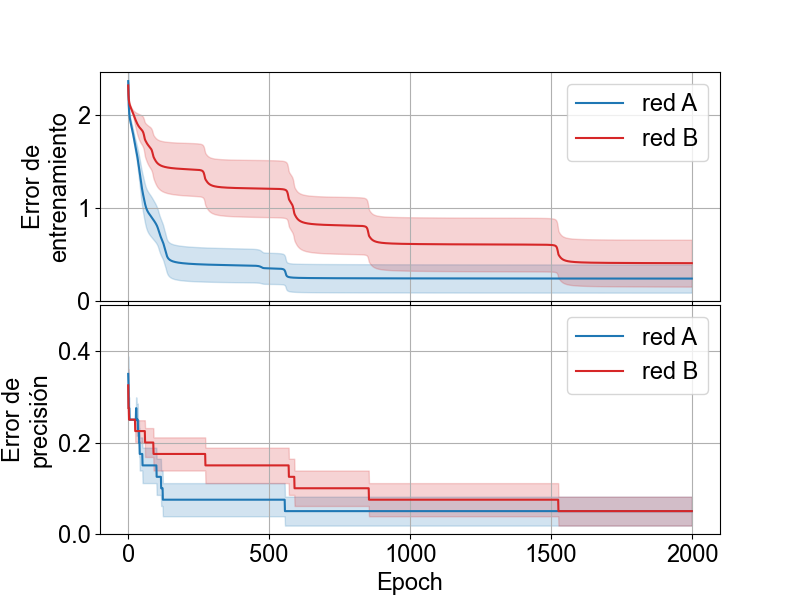

In [7]:
#Grafico

fig, ax = plt.subplots(2, 1, figsize = (8,6), sharex=True)
fig.subplots_adjust(hspace=0.02)

#Red A:
ax[0].plot(A_e_loss_mean, label = "red A", color = "tab:blue")
ax[0].fill_between(np.arange(N_epochs), A_e_loss_mean - A_e_loss_std, A_e_loss_mean + A_e_loss_std, alpha = 0.2, color = "tab:blue")
ax[1].plot(A_validation_mean, label = "red A", color = "tab:blue")
ax[1].fill_between(np.arange(N_epochs), A_validation_mean - A_validation_std, A_validation_mean + A_validation_std, alpha = 0.2, color = "tab:blue")
#Red B:
ax[0].plot(B_e_loss_mean, label = "red B", color = "tab:red")
ax[0].fill_between(np.arange(N_epochs), B_e_loss_mean - B_e_loss_std, B_e_loss_mean + B_e_loss_std, alpha = 0.2, color = "tab:red")
ax[1].plot(B_validation_mean, label = "red B", color = "tab:red")
ax[1].fill_between(np.arange(N_epochs), B_validation_mean - B_validation_std, B_validation_mean + B_validation_std, alpha = 0.2, color = "tab:red")

#Decoración
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Error de\nentrenamiento")
ax[1].set_ylabel("Error de\nprecisión")

ax[0].grid(); ax[1].grid()

ax[0].set_ylim([0, np.max(np.array([np.max(A_e_loss_mean + A_e_loss_std), np.max(B_e_loss_mean + B_e_loss_std)] ) )])
ax[1].set_ylim([0, 0.5])

ax[0].legend()
ax[1].legend()

plt.show()

#Guardo la figura
fig.savefig("Figures/ej_1.pdf", bbox_inches='tight')



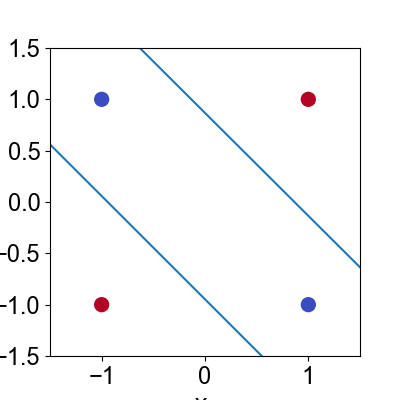

In [10]:
#Grafico x_data
fig, ax = plt.subplots(1, 1, figsize = (4,4))

ax.scatter(x_data[:,0], x_data[:,1], c = y_data, cmap = "coolwarm", s = 100)
#Añado el hiperplano definido por los pesos de cada red
x_vec = np.linspace(-1.5, 1.5, 100)
A_pesos_1 = A_red_final["pesos"][0]
A_pesos_2 = A_red_final["pesos"][1]
B_pesos_1 = B_red_final["pesos"][0]
B_pesos_2 = B_red_final["pesos"][1]

#Red A
y_vec_A_1_1 = -(A_pesos_1[0,0]*x_vec + A_pesos_1[2,0])/A_pesos_1[1,0]
y_vec_A_1_2 = -(A_pesos_1[0,1]*x_vec + A_pesos_1[2,1])/A_pesos_1[1,1]
y_vec_A_2 = -(A_pesos_2[0]*x_vec + A_pesos_2[2])/A_pesos_2[1]




ax.plot(x_vec, y_vec_A_1_1, label = "Red A", color = "tab:blue")
ax.plot(x_vec, y_vec_A_1_2, label = "Red A", color = "tab:blue")
# ax.plot(x_vec, y_vec_A_2, label = "Red A", color = "tab:blue") #Qué significa este w?



ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
# ax.set_title("Datos")

plt.show()


In [9]:
error

NameError: name 'error' is not defined

## Ejercicio 2

In [ ]:
from itertools import product

#Defino ejemplos a aprender
def XOR_gral(x_vec):
    #x[i] = +/- 1 for all i
    return np.prod(x_vec, axis = 0) 

def generate_matrix(N):
    # Generar todas las combinaciones posibles de 0s y 1s de longitud N
    combinations = product([-1, 1], repeat=N)
    # Convertir las combinaciones a una matriz de numpy
    matrix = np.array(list(combinations))
    return matrix



def RN_XOR_gral(N_prima_array, x_data, y_data, N_CI, N_epochs):

    N = len(x_data[0]) #Nro de entradas

    #Def la seed
    np.random.seed(1) #Para obtener siempre el mismo resultado

    e_loss_mean_matrix = np.empty([len(N_prima_array), N_epochs])
    e_loss_std_matrix = np.empty([len(N_prima_array), N_epochs])
    validation_mean_matrix = np.empty([len(N_prima_array), N_epochs])
    validation_std_matrix = np.empty([len(N_prima_array), N_epochs])


    for i, N_prima in enumerate(N_prima_array):

        def red_C(w_ini_max):
            return {"name": "C", "input":N, "hidden":N_prima, "output":1, "pesos":[np.random.rand(N+1,N_prima)*w_ini_max, np.random.rand(N_prima+1,1)*w_ini_max]}

        #Entreno red C
        eta = 0.1

        e_loss_mean_matrix[i], e_loss_std_matrix[i], validation_mean_matrix[i], validation_std_matrix[i], red_final = aprendizaje_redes(N_CI, N_epochs, red_C, x_data, y_data, eta = eta)


    return e_loss_mean_matrix, e_loss_std_matrix, validation_mean_matrix, validation_std_matrix



In [ ]:
#Genero datos

N = 5

x_data = generate_matrix(N)
y_data = np.empty(2**N)
for i in range(2**N):
    y_data[i] = XOR_gral(x_data[i])


In [ ]:
#Entreno

N_prima_array = [1, 3, 5, 7, 9, 11]
N_CI = 10
N_epochs = 4000

e_loss_mean_matrix, e_loss_std_matrix, validation_mean_matrix, validation_std_matrix = RN_XOR_gral(N_prima_array, x_data, y_data, N_CI, N_epochs)

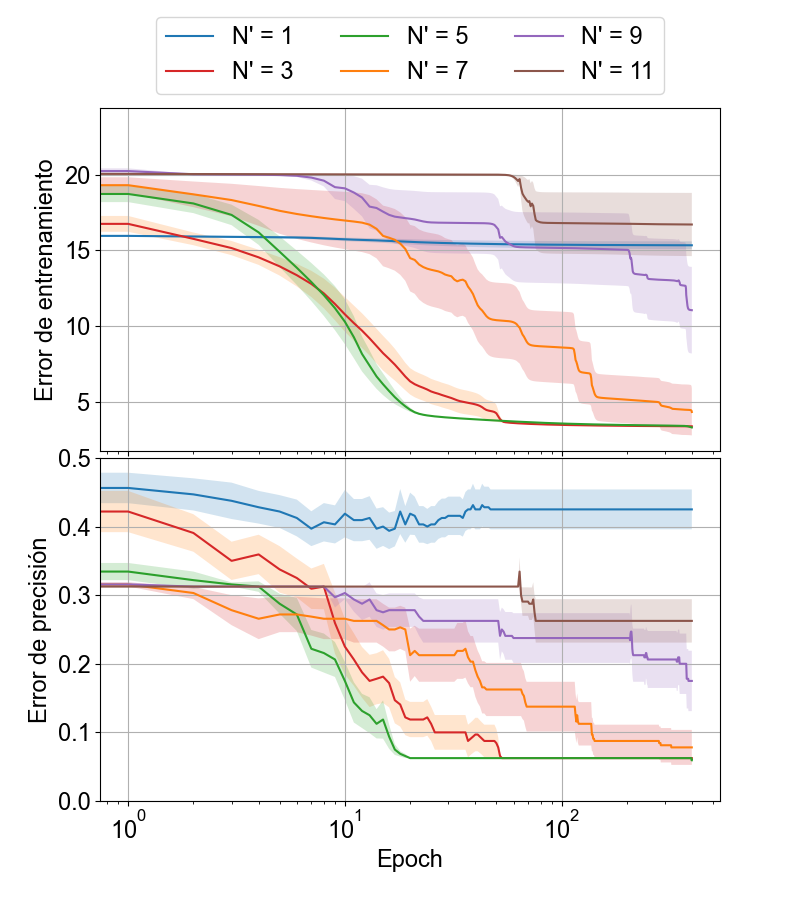

In [ ]:
#Calculo y grafico

fig, ax = plt.subplots(2, 1, figsize = (8,9), sharex=True, squeeze=True)
#Junto las subplots 
fig.subplots_adjust(hspace=0.02)

#labels
N_prima_labels = []
for i in range(len(N_prima_array)):
    N_prima_labels.append("N' = " + str(N_prima_array[i]))

colors = ["tab:blue", "tab:red", "tab:green", "tab:orange", "tab:purple", "tab:brown"]

#Grafico e_loss_mean_matrix.T
for i in range(len(N_prima_array)):
    ax[0].plot(e_loss_mean_matrix[i], label = N_prima_labels[i], color = colors[i])
    ax[0].fill_between(np.arange(N_epochs), e_loss_mean_matrix[i] - e_loss_std_matrix[i], e_loss_mean_matrix[i] + e_loss_std_matrix[i], alpha = 0.2)
for i in range(len(N_prima_array)):
    ax[1].plot(validation_mean_matrix[i], label = N_prima_labels[i], color = colors[i])
    ax[1].fill_between(np.arange(N_epochs), validation_mean_matrix[i] - validation_std_matrix[i], validation_mean_matrix[i] + validation_std_matrix[i], alpha = 0.2)

#Decoración
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Error de entrenamiento")
ax[1].set_ylabel("Error de precisión")

ax[0].set_xscale("log")
ax[1].set_xscale("log")

ax[1].set_ylim([0, 0.5])
# ax[0].set_ylim([0, np.max(np.array([np.max(A_e_loss_mean + A_e_loss_std), np.max(B_e_loss_mean + B_e_loss_std)] ) )])

ax[0].grid()
ax[1].grid()



#Agrego legend fuera del gráfico arriba de todo
ax[0].legend(loc = "upper center", bbox_to_anchor=(0.5, 1.3), ncol = 3)



plt.show()

#Guardo figura
fig.savefig("Figures/ej_2_vs_epochs.pdf", bbox_inches='tight')



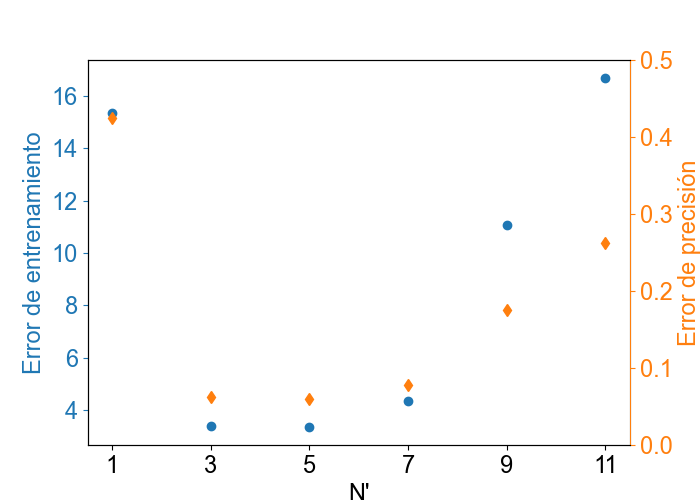

In [ ]:
#Grafico el último valor de error de enetrenamiento y de validación como función de N'
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(N_prima_array, e_loss_mean_matrix[:,-1], "o")
ax.set_xlabel("N'")
ax.set_ylabel("Error de entrenamiento", color = "tab:blue")
#Agrego los ticks en x sobre N_prima_array
ax.spines['right'].set_color('tab:blue')
ax.tick_params(axis='y', colors='tab:blue')
ax.set_xticks(N_prima_array)

#En el eje derecho grafico e_validation
ax2 = ax.twinx()
#Pinto eje y ticks de naranja
ax2.spines['right'].set_color('tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')
ax2.plot(N_prima_array, validation_mean_matrix[:,-1], "d", color = "tab:orange")
ax2.set_ylabel("Error de precisión", color = "tab:orange")
ax2.set_ylim([0, 0.5])


plt.show()

#Guardo figura
fig.savefig("Figures/ej_2_vs_N_prima.pdf", bbox_inches='tight')